# Customer Churn Prediction 

**Importing**

In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [356]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE # For over sampling (solving class imbalance issue)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

In [357]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle # To save files

**Data**

In [358]:
df = pd.read_csv("Customer-Churn.csv")

In [359]:
df.shape

(7043, 21)

In [360]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [362]:
# Why TotalCharges is object?
print(df.TotalCharges)

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object


In [363]:
# Converting TotalCharges to float values

# df['TotalCharges']=df['TotalCharges'].astype(float)  #Right     df['TotalCharges'] is a Pd Series

# df['TotalCharges']=float(df['TotalCharges'])  #Wrong          float() expects a single value, not a Series.

Above code gives error, which means there is something wrong with the column

In [364]:
x=df["TotalCharges"].unique()
print(x)
type(x)

['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


numpy.ndarray

**method-1** <br>
Even if already string, we make sure by: str(val) <br>
Remove the first decimal point (if any): str(val).replace('.' ,  '', 1) . Only first because eg. 25...<br>
Check if the result is all digits: .isdigit()  eg. '2985' .isdigit() returns True, so '29.85' is numeric, But ' ' or 'abc' not.

In [365]:
# non_numeric = [val for val in x if not str(val).replace('.', '', 1).isdigit()]
# print(non_numeric)

**Method-2**<br>
pd.to_numeric(..., errors='coerce') turns invalid values into NaN.<br>
notna() finds valid ones — so we negate ~ to get invalid rows.<br>
Then we print their unique() values.

In [366]:
invalid_values = df[~pd.to_numeric(df["TotalCharges"], errors='coerce').notna()]["TotalCharges"].unique()
print(invalid_values)

[' ']


In [367]:
df[df["TotalCharges"]==" "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [368]:
rows_num=df[df["TotalCharges"]==" "].shape[0]
rows_num

11

In [369]:
df["TotalCharges"] = df["TotalCharges"].replace({" ": "0.0"})

In [370]:
df['TotalCharges']=df['TotalCharges'].astype(float)

In [371]:
df["TotalCharges"].dtype  # Now Okay

dtype('float64')

In [372]:
# Why SeniouCitizen is int?

print(df["SeniorCitizen"].unique())

[0 1]


In [373]:
# customerID column is not required for anything

df.drop(columns=["customerID"],inplace=True)

In [374]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [375]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [376]:
# To check if there is only 2 categories with no capitalization issue
print(df["gender"].unique())

['Female' 'Male']


In [377]:
# printing the unique values in all the columns

numerical_col_list = ["tenure", "MonthlyCharges", "TotalCharges"] #didn't include SeniorCitizen col because it is binary classified

for col in df.columns:
  if col not in numerical_col_list:
    print(col, df[col].unique(), "\n",sep=" ")

gender ['Female' 'Male'] 

SeniorCitizen [0 1] 

Partner ['Yes' 'No'] 

Dependents ['No' 'Yes'] 

PhoneService ['No' 'Yes'] 

MultipleLines ['No phone service' 'No' 'Yes'] 

InternetService ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity ['No' 'Yes' 'No internet service'] 

OnlineBackup ['Yes' 'No' 'No internet service'] 

DeviceProtection ['No' 'Yes' 'No internet service'] 

TechSupport ['No' 'Yes' 'No internet service'] 

StreamingTV ['No' 'Yes' 'No internet service'] 

StreamingMovies ['No' 'Yes' 'No internet service'] 

Contract ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling ['Yes' 'No'] 

PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

Churn ['No' 'Yes'] 



In [378]:
# class distribution of Churn column
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


**3. Exploratory Data Analysis (EDA)**

In [379]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


**Plots**

For numeric columns


In [380]:
#creating a function for preventing repetitiveness in plots
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True,bins=30)
  plt.title(f"Distribution of {column_name}")

  # add vertical lines for mean and median
  
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

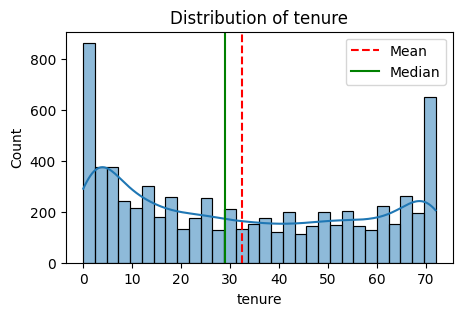

In [381]:
plot_histogram(df, "tenure")

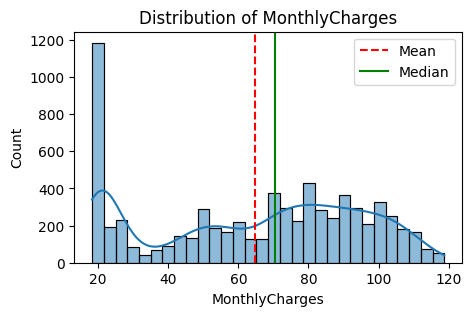

In [382]:
plot_histogram(df, "MonthlyCharges")

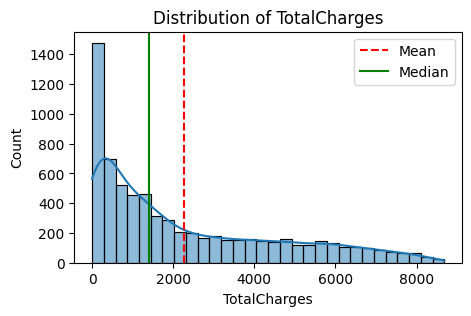

In [383]:
plot_histogram(df, "TotalCharges")

Above is a right skewed graph, linear models like linear reg, logistic reg, lasso or models like svm don't work well with these kind of data. They work well with normally distributed data.

**Box plot for numerical features**

In [384]:
def plot_boxplot(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.boxplot(y=df[column_name])
  plt.title(f"Box Plot of {column_name}")
  plt.ylabel(column_name)
  plt.show

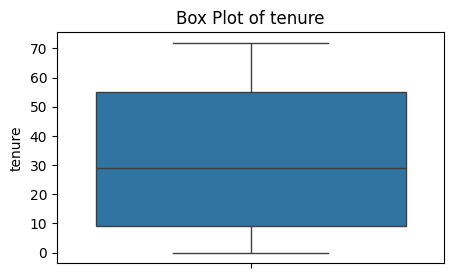

In [385]:
plot_boxplot(df, "tenure") 

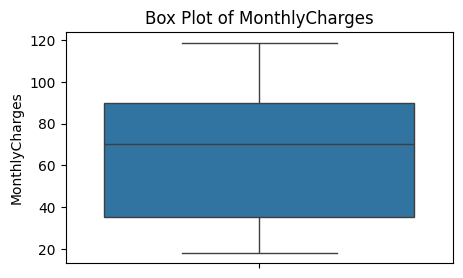

In [386]:
plot_boxplot(df, "MonthlyCharges")

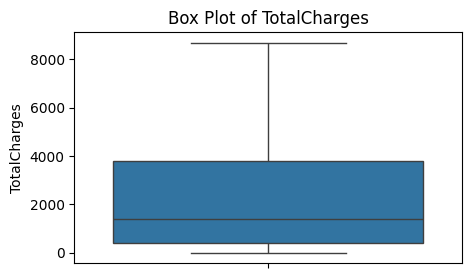

In [387]:
plot_boxplot(df, "TotalCharges")

**Correlation Heatmap for numerical columns**

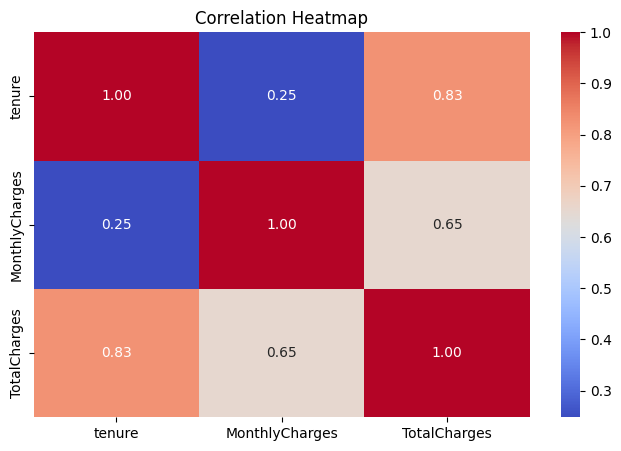

In [388]:
# correlation matrix - heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")                                                  # fmt parameter tells how many decimal places to show
plt.show()

tenure and total charges are highly correlated so we can remove one of the column which might reduce multicollinearity, resulting in better result.

**Categorical columns**

In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


all categorical columns have data type="objects"

In [390]:
object_cols = df.select_dtypes(include="object").columns.to_list()

object_cols += ["SeniorCitizen"] 

In [391]:
for col in object_cols:
    print(f"{col}: {df[col].dtype}")

gender: object
Partner: object
Dependents: object
PhoneService: object
MultipleLines: object
InternetService: object
OnlineSecurity: object
OnlineBackup: object
DeviceProtection: object
TechSupport: object
StreamingTV: object
StreamingMovies: object
Contract: object
PaperlessBilling: object
PaymentMethod: object
Churn: object
SeniorCitizen: int64


Countplot for **categorical columns**

In [392]:
# for col in object_cols:
#   plt.figure(figsize=(5, 3))
#   sns.countplot(x=df[col])
#   plt.title(f"Count Plot of {col}")
#   plt.tight_layout()
#   plt.show()

In [393]:
# for i in range(0, len(object_cols), 2):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

#     for j in range(2):
#         if i + j < len(object_cols):
#             col = object_cols[i + j]
#             sns.countplot(x=df[col], ax=axes[j])
#             axes[j].set_title(f"Count Plot of {col}")
#             axes[j].tick_params(axis='x', rotation=30)

#     plt.tight_layout()
#     plt.show()

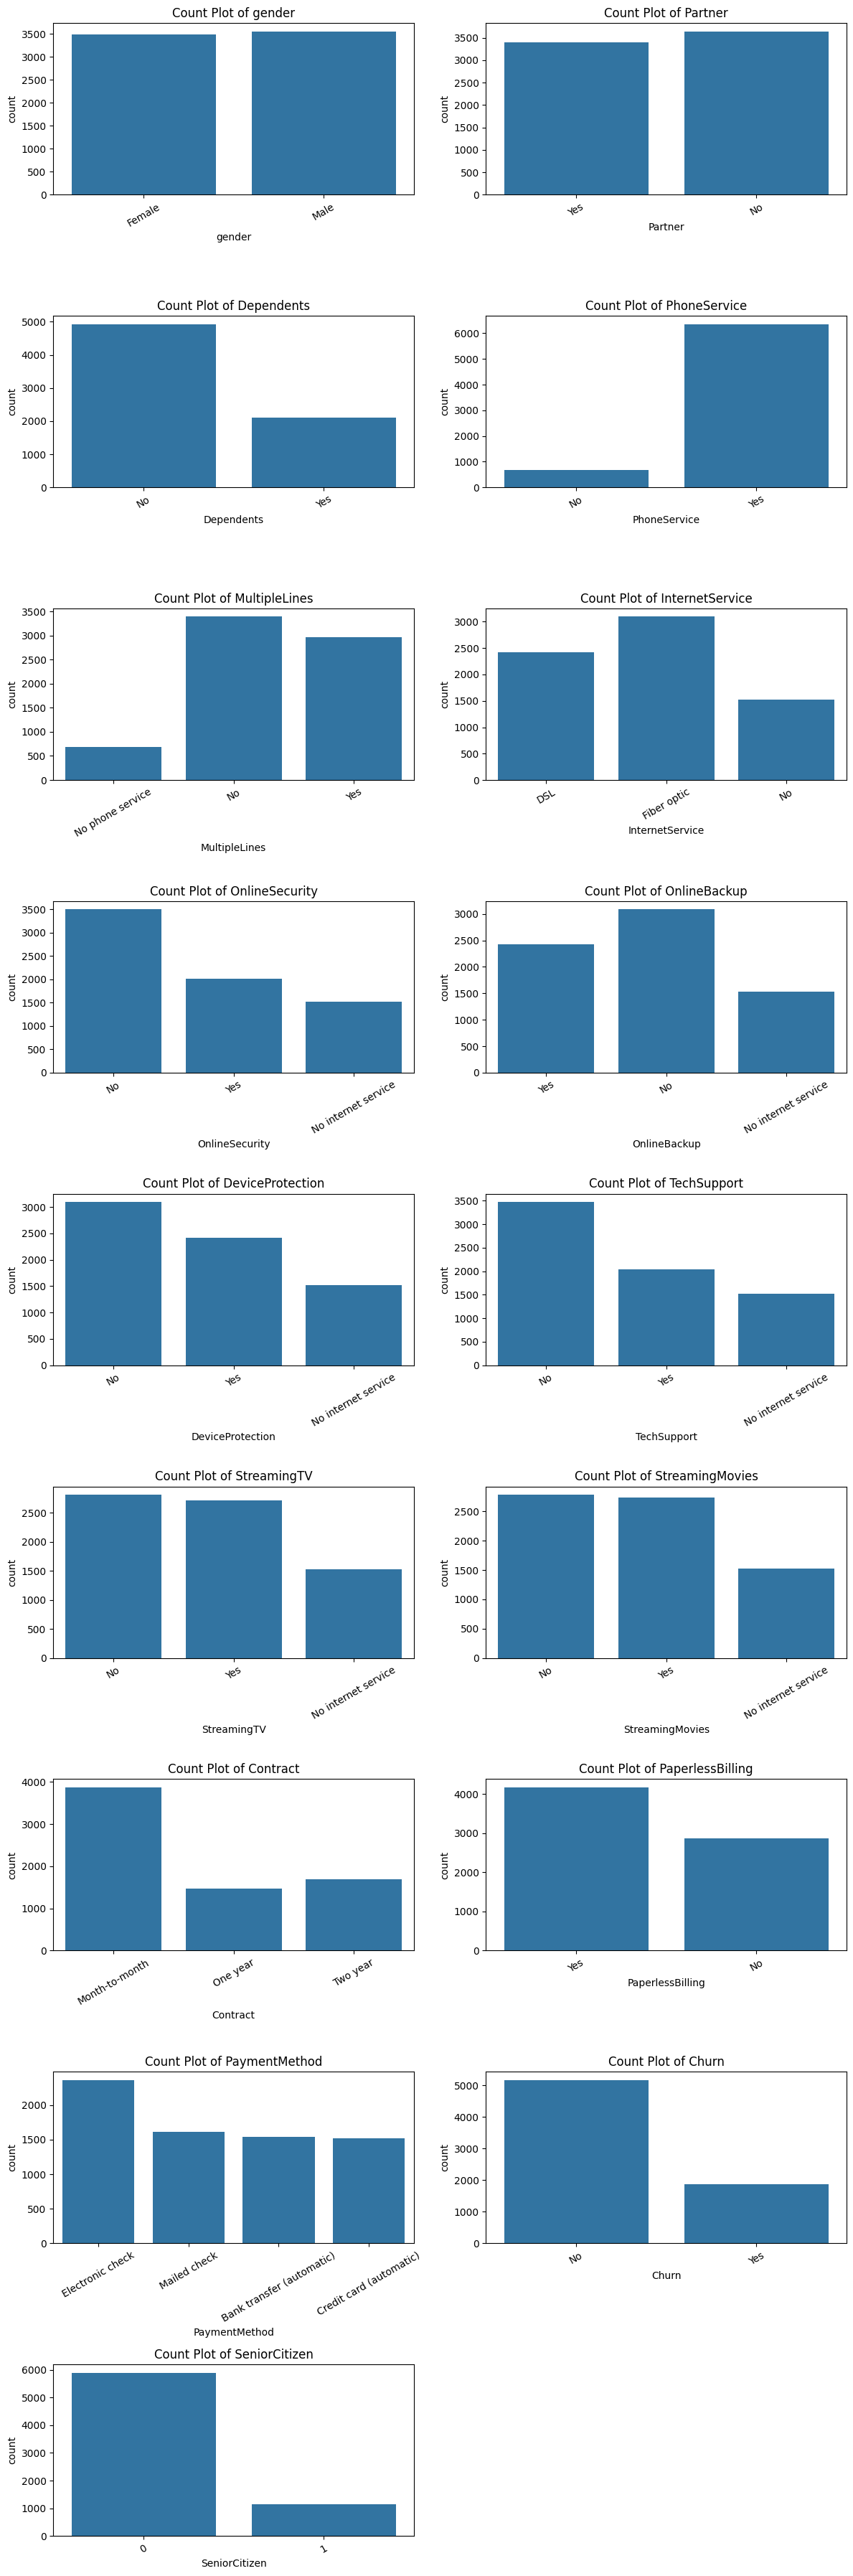

In [394]:
import math
# Number of plots
n = len(object_cols)
rows = math.ceil(n / 2)  #.ceil() rounds up and .floor() rounds down

fig, axes = plt.subplots(rows, 2, figsize=(2*6, rows*4))

# Loop over rows and columns
plot_index = 0
for r in range(rows):
    for c in range(2):
        if plot_index < n:
            col = object_cols[plot_index]
            sns.countplot(x=df[col], ax=axes[r][c])
            axes[r][c].set_title(f"Count Plot of {col}")
            axes[r][c].tick_params(axis='x', rotation=30)
            plot_index += 1
        else:
            axes[r][c].axis('off')  # Hide empty subplot if plots < grid slots

plt.tight_layout()
plt.show()

**4. Data Preprocessing**

Label encoding of target column

In [395]:
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [396]:
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0}).astype(int)

C:\Users\aksha\AppData\Local\Temp\ipykernel_44056\631888689.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0}).astype(int)


In [397]:
print(df["Churn"].value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


Label encoding of categorical fetaures

In [398]:
# identifying columns with object data type
object_columns = df.select_dtypes(include="object").columns

In [399]:
print(object_columns)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [400]:
# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_columns:
  LE= LabelEncoder()
  df[column] = LE.fit_transform(df[column])
  encoders[column] = LE


# save the encoders to a pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)


In [403]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

If we do one hot encoding the no. of columns in df will increase very much. Hence we are doing Label Encoding.

In [404]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


**Traianing and test data split**

In [405]:
# splitting the features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [406]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

If we used method like logistic reg, svm etc then we would have scaled the data first on Tenure, monthly charges, total charges (cause the are large values as compared to others). But tree methods dont require scaling.

In [407]:
print(y_train.shape)

(5634,)


In [408]:
print(y_train.value_counts())

Churn
0    4139
1    1495
Name: count, dtype: int64


Synthetic Minority Oversampling TEchnique (SMOTE)

In [409]:
smote = SMOTE(random_state=101)

In [410]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [411]:
print(X_train_smote.shape)

(8278, 19)


In [412]:
print(y_train_smote.shape)

(8278,)


In [413]:
print(y_train_smote.value_counts())

Churn
0    4139
1    4139
Name: count, dtype: int64


**5. Model Training**

Training with default hyperparameters

In [414]:
# dictionary of models

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=101),
    "Random Forest": RandomForestClassifier(random_state=101),
    "XGBoost": XGBClassifier(random_state=101),
    "KNN": KNeighborsClassifier(n_neighbors = 5),
    "Logistic Regression": LogisticRegression(random_state=101, max_iter=10000),
}

we could have scaled data for logistic reg to decrease max_iter but it only gave 80% accuracy so we didn't do it. 

In [415]:
models.items()

dict_items([('Decision Tree', DecisionTreeClassifier(random_state=101)), ('Random Forest', RandomForestClassifier(random_state=101)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)), ('KNN', KNeighborsClassifier()), ('Logistic Regression', LogisticRegression(max_iter=10000,

In [416]:
from sklearn.model_selection import StratifiedKFold

# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=StratifiedKFold(5, shuffle=True, random_state=100), scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.4f}")
  print("\n")

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.7971


Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.8520


Training XGBoost with default parameters
XGBoost cross-validation accuracy: 0.8478


Training KNN with default parameters
KNN cross-validation accuracy: 0.7706


Training Logistic Regression with default parameters
Logistic Regression cross-validation accuracy: 0.8056




We used "cv=StratifiedKFold(5, shuffle=True, random_state=100)" instead of just "cv=5" because we had imbalance Churn column with "yes">>"no". Therefore to keep a balance in ratio yes's and no's (same as our real data) in each fold. When we just used "cv=5" our cv_score first 2 folds had 10-15% less accuracy than others due to the imbalance in the folds. 

In [417]:
cv_scores

{'Decision Tree': array([0.81702899, 0.7807971 , 0.79468599, 0.78912387, 0.80362538]),
 'Random Forest': array([0.86775362, 0.84842995, 0.84842995, 0.8429003 , 0.85256798]),
 'XGBoost': array([0.85929952, 0.84178744, 0.84722222, 0.84410876, 0.84652568]),
 'KNN': array([0.78381643, 0.77838164, 0.74516908, 0.78429003, 0.76132931]),
 'Logistic Regression': array([0.81884058, 0.79951691, 0.79347826, 0.81450151, 0.80181269])}

Random Forest gives the highest accuracy compared to other models with default parameters. (hence we proceed working with this model)

In [419]:
rfc = RandomForestClassifier(random_state=100)

In [420]:
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=100)

In [421]:
print(y_test.value_counts())

Churn
0    1035
1     374
Name: count, dtype: int64


**6. Model Evaluation**

In [422]:
# evaluate on test data
y_test_pred = rfc.predict(X_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confsuion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.7629524485450674
Confsuion Matrix:
 [[865 170]
 [164 210]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1035
           1       0.55      0.56      0.56       374

    accuracy                           0.76      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.76      0.76      0.76      1409



In [423]:
# save the trained model as a pickle file
model_data = {"model": rfc, "features_names": X.columns.tolist()}


with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

**7. Load the saved  model and  build a Predictive System**

In [424]:
# load the saved model and the feature names

with open("customer_churn_model.pkl", "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]

In [425]:
print(loaded_model)

RandomForestClassifier(random_state=100)


In [426]:
print(feature_names)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [276]:
encoders.items()

dict_items([('gender', LabelEncoder()), ('Partner', LabelEncoder()), ('Dependents', LabelEncoder()), ('PhoneService', LabelEncoder()), ('MultipleLines', LabelEncoder()), ('InternetService', LabelEncoder()), ('OnlineSecurity', LabelEncoder()), ('OnlineBackup', LabelEncoder()), ('DeviceProtection', LabelEncoder()), ('TechSupport', LabelEncoder()), ('StreamingTV', LabelEncoder()), ('StreamingMovies', LabelEncoder()), ('Contract', LabelEncoder()), ('PaperlessBilling', LabelEncoder()), ('PaymentMethod', LabelEncoder()), ('Churn', LabelEncoder())])

In [431]:
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85,
}


input_data_df = pd.DataFrame([input_data])

with open("encoders.pkl", "rb") as f:
  encoders = pickle.load(f)


# encode categorical featires using the saved encoders
for column, encoder in encoders.items():
  input_data_df[column] = encoder.transform(input_data_df[column])

# make a prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)

print(prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

[0]
Prediction: No Churn
Prediciton Probability: [[0.77 0.23]]


**Finished**